# Interpolation Part 1: Linear Interpolation


In this chapter we will consider the approximation of a set of discrete data points by various types of functions.

*Interpolation* is the construction of a function $f(x)$ that fits a known set of data points $(x_k,y_k)$. Such a function can then be evaluated at new data points within the known interval. 

*Extrapolation* is similar to interpolation but applies when the unknown evaluation points lie outside the range of known data points. 

The *Lagrange polynomial* is the polynomial of least degree such that at each point $x_j$ the polynomial assumes the corresponding value $y_j$. This polynomial is unique but there are various ways of finding it.

Given a sequence of $n$ distinct numbers $x_k$ (called knots) with corresponding $y_k$ we are looking for a function $f(x)$ such that
$f(x_k) = y_k,\, k = 0,1,...,n-1.$

Each pair $(x_k,y_k)$ is called a *data point* and $f$ is called the *interpolant* for the data points.


## Linear interpolation

Arguably the simplest form of Lagrange polynomial is to compute the line between two data points, this is the first degree Lagrange interpolating polynomial. We are seeking an interpolant of the form

$$p_1(x) = mx + c$$

where $m$ and $c$ are unknowns to be determined by the two data points $(x_0,y_0)$ and $(x_1,y_1).$ Plugging these two points into our interpolating function gives the linear equations

$y_0 = mx_0 + c$ and $y_1 = mx_1 + c$


in $m$ and $c.$ We solve these simultaneously to obtain

$m = \frac{y_0-y_1}{x_0-x_1}$ and $c = y_0 - \frac{y_0-y_1}{x_0-x_1}x_0 $ and the interpolant can be written as

$p_1(x) = \frac{y_0-y_1}{x_0-x_1}x + y_0 - \frac{y_0-y_1}{x_0-x_1}x_0$

or

$p_1(x) = y_0 + \frac{y_0-y_1}{x_0-x_1}(x-x_0) $

or in 'Lagrange form'

$p_1(x) = \frac{x-x_1}{x_0-x_1}y_0 + \frac{x-x_0}{x_1-x_0}y_1 $


<font color='#2F4F4F'>
    
### Application

In Python creating a linear function between two points is quite straight forward, only we need to take a little care about what our arguments should be. It is likely we want to have a general purpose interpolating function for a given point pair $(x_0,y_0),$ $(x_1,y_1).$ The simplest thing to do is have the independent variable $x$ *and* the point pair $(x_0,y_0),$ $(x_1,y_1)$ as the arguments: </font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})            # Increase the font size to 14pt

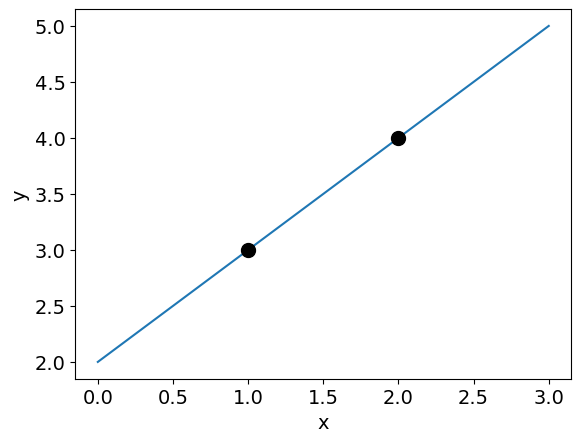

In [2]:
def p1_basic(x,x0,x1,y0,y1):
    return y0*(x-x1)/(x0-x1)+y1*(x-x0)/(x1-x0)

x = np.linspace(0,3)

# call point pair a and b in this example
xa = 1 
xb = 2 
ya = 3 
yb = 4

plt.figure()
plt.plot(x,p1_basic(x,xa,xb,ya,yb))
plt.plot(xa,ya,'ko',ms=10) # plot interpolating point 1
plt.plot(xb,yb,'ko',ms=10) # plot interpolating point 2
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<font color='#2F4F4F'>

This works perfectly well but is a little unweildy if it needs to be used a lot.

We can make use of a *lambda* function to generalise a little. In Python a lambda function is a single expression function defined as follows </font>

In [3]:
# Simple example

f = lambda x: 2*x + 3

print(f(2), f(30.2))

7 63.4


<font color='#2F4F4F'>
    You might wonder what help this is here. Well, we can embed a lambda function within a regular function such that the returned result is a function. For instance for a linear interpolation function we can create a general function which accepts the point pairs and returns for us the interpolating function, rather than above where we had to provide the interpolating data at the same time.

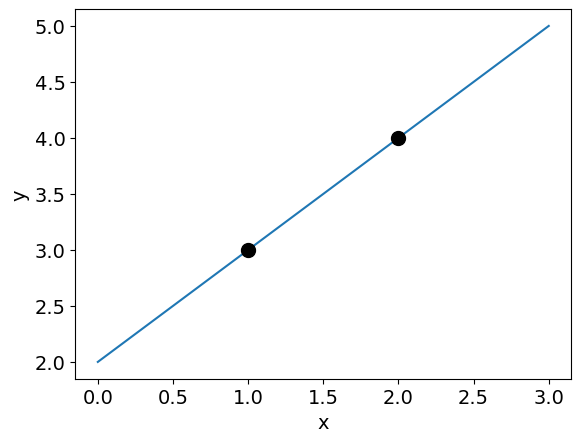

In [15]:
def p1(x0,x1,y0,y1): # this function creates the linear *interpolant* between these two points
    return lambda x : y0*(x-x1)/(x0-x1)+y1*(x-x0)/(x1-x0)

# The alternative
def p1_alt(x0,x1,y0,y1): # this function creates the linear *interpolant* between these two points
    def temp(x):
        return y0*(x-x1)/(x0-x1)+y1*(x-x0)/(x1-x0)
    return temp


myp1 = p1_alt(1,2,3,4)  # now myp1 is the interpolating function

x = np.linspace(0,3)

plt.figure()
plt.plot(x,myp1(x))
plt.plot(1,3,'ko',ms=10)
plt.plot(2,4,'ko',ms=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Piecewise linear interpolation

It is fairly uncommon to only have two pieces of data, rather more likely is to have a set of $n$ data points $(x_k,y_k),$ $k=0,1,...,n-1$ that partition $x\in[a,b]$ into subintervals $[x_k,x_{l+1}]$ where $$ a=x_0 < x_1<x2<...<x_{n-1}=b; $$ these are the knots referred to at the start of the notebook.

The natural extension to the linear interpolant above, is to form a piecewise function which connects line segments through each subinterval, or consecutive data points. This is *piecewise linear interpolation*.

Using the interpolant formula above, the interpolant for $x\in[x_k,x_{k+1}]$ will be

$$p_{1k}(x) = \frac{x-x_{k+1}}{x_k-x_{k+1}}y_k + \frac{x-x_k}{x_{k+1}-x_k}y_{k+1}.$$

Note that the full interpolating function will be continuous but will not be differentiable at the knots as, in general, the slopes of the individual interpolants will change there.

<font color='#2F4F4F'>
    
### Application
    
In actual fact, this process is all that `plt.plot` produces; it will draw lines between adjacent points. This is fine for visualisation, but if we want to obtain new data or perform some extra manipulation we will need a code to give us the interpolant.
    
As above the simplest approach is to perform the whole process in one go; i.e. have the function take the knots *and* the new evaluation points as its arguments and return the interpolated evaluation data.

In [5]:
def piece_p1_v1(x,x0,y0):
    # Now we expect there to be more than a pair of knots
    # First we wish to determine in which subinterval our unknown lies
    # Simplest to implement/understand is to take each point in turn
    # and decide which segment it belongs to
    
    N = np.size(x)   # new evaluation points
    M = np.size(x0)  # original data points
    
    y = np.zeros_like(x)
    
    for i in range(N):
        k = 0         
        for j in range(M-1): # 1 fewer segments to points
            if((x[i]>=x0[j] and x[i]<x0[j+1]) or (x[i]==x0[j+1])): # check if in a segment or equal to the last knot
                    k = j
        
        # Note if equal to a knot we don't need to do anything special, just not skip it
        
        y[i] = y0[k]*(x[i]-x0[k+1])/(x0[k]-x0[k+1]) + y0[k+1]*(x[i]-x0[k])/(x0[k+1]-x0[k])

    return y


<font color='#2F4F4F'>

Let's test on $f(x) = \sin(x)$ on $x\in[0,10]$

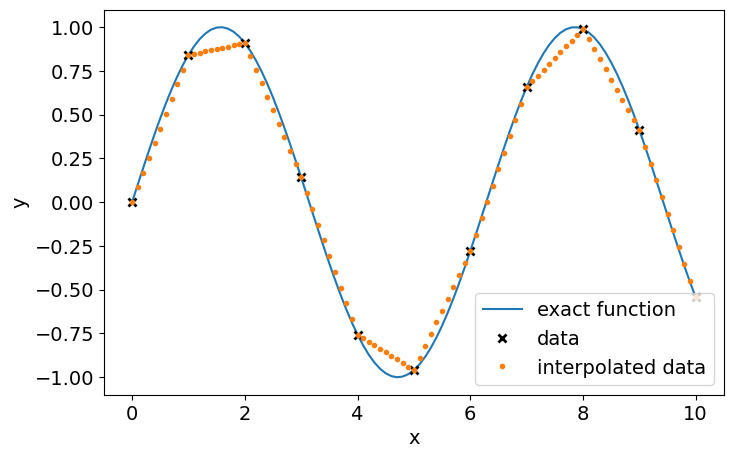

In [6]:
M = 11
x0 = np.linspace(0,10,M)
y0 = np.sin(x0)

N = 101

x = np.linspace(0,10.0,N)   # new evaluation points
y = piece_p1_v1(x,x0,y0)

plt.figure(figsize=(8,5))
plt.plot(x,np.sin(x),label='exact function')
plt.plot(x0,y0,'kx',mew=2,label='data')
plt.plot(x,y,'.',label='interpolated data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

<font color='#2F4F4F'>

**Finding the subinterval**

In the example above we used a costly loop to take each point in turn and then check which subinterval it lies in. Below we will see how to avoid the loop in general but for now let us consider the common situation where the data is evenly spaced. If this is the case we have that

$$ x_k \in \{a,a+h,a+2h,...,a+Nh=b\}$$

for $N$ data points with spacing $h=\frac{b-a}{N-1}.$ 
    
With such a set up we can calculate the subinterval, $j,$ in which the point $x$ lies via 

$$ 
j = \left \lfloor \frac{x-a}{h} \right \rfloor
$$ 
    
(where $\lfloor x\rfloor$ is the [floor function](https://en.wikipedia.org/wiki/Floor_and_ceiling_functions)). Not only does this simplify the code but it also gives a simple way to avoid looping to check each point/subinterval in turn.
    

In [7]:
def piece_p1_v2(x,x0,y0):
    # This version relies on the data being evenly spaced
    
    N = np.size(x)   # new evaluation points
    M = np.size(x0)  # original data points
    
    y = np.zeros_like(x)
    
    h = (x0[-1]-x0[0])/(M-1)                  # assumed spacing
    if ((x0[1:]-x0[0:-1])==h).all() :         # check if regularly spaced
        
        k = np.minimum(M-2,(x/h).astype(int)) # making sure we don't overshoot the last subinterval
        ip = np.arange(N)                     # indexing array to align k with evaluation points
        
    else:
        print('error, not evenly spaced data!')
        return
    y[ip] = y0[k[ip]]*(x[ip]-x0[k[ip]+1])/(x0[k[ip]]-x0[k[ip]+1]) + y0[k[ip]+1]*(x[ip]-x0[k[ip]])/(x0[k[ip]+1]-x0[k[ip]])

    return y


<font color='#2F4F4F'>

### Array Broadcasting

For the sake of generality we now consider how to avoid looping with points which may not be evenly spaced.

The idea here is to use the `p1` general linear interpolation function above to return `M` functions for each segment of the data. We can then use a *mask* to select which function is appropriate for the evaluation points. 

In order for the mask to work, we need to take the $N$ pieces of new data and *broadcast* them to the $M$ segments for checking. Python can manage this provided these 1D arrays are orthogonal to each other, i.e. $(1,N) \times (1,M)$ will not work as the operation is ambiguous; do we mean to element-wise multiply the two arrays of different sizes? Instead we broadcast e.g. $(1,N) \times (M,1)$ to give an $(M,N)$ result. Note for our mask our binary operation isn't arithmetic but boolean; we want to check a set of logical less than, equals etc. 

The result, below, is `ij` an array which is of shape `(N,M)` which is `True` if the $i^{th}$ point of $N$ new data points lies in the $j^{th}$ segment of $M$ original data points (also accounting for the possibility of the new data being outside the original observation region). Apply this to the $M$ functions evaluated as the $N$ data points gives the required piecewise linear representation. Note without the mask we get all $M$ functions evaluated at all $N$ new data points!  

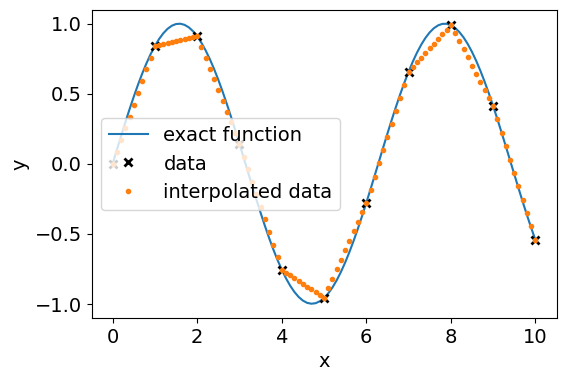

In [8]:
xt = (np.reshape(x,(1,N)))
xt0 = np.reshape(x0,(M,1))
yt0 = np.reshape(y0,(M,1))

testp1 = p1(xt0[0:-1],xt0[1:],yt0[0:-1],yt0[1:])  # Returns M linear functions

# Mask which gives a True/False on an NxM grid 
ij = ((xt<xt0[1:]) & (xt>=xt0[:-1])) | ((xt0[1:]==xt) & (xt>xt0[:-1]).all(axis=0)) 
ij[-1,:] = ((xt>xt0).all(axis=0)| ij[-1,:])
ij[0,:] = ((xt<xt0).all(axis=0)| ij[0,:])

yt = testp1(xt)[ij]                               # Picks the appropriate function for the point in xt

plt.figure(figsize=(6,4))
plt.plot(x,np.sin(x),label='exact function')
plt.plot(x0,y0,'kx',mew=2,label='data')
plt.plot(x,yt,'.',label='interpolated data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

<font color='#2F4F4F'>

We can go a little further with our implementation now we have a compact code, we can create a function which will, given the data points (knots) return for us the piecewise interpolating function which we can then evaluate at whatever points we provide. This just wraps up the code above and returns a function name rather than the interpolated data.

In [9]:
def piece_p1_v3(x0,y0):

    M = np.size(x0)
    xt0 = np.reshape(x0,(M,1))
    yt0 = np.reshape(y0,(M,1))

    testp1 = p1(xt0[0:-1],xt0[1:],yt0[0:-1],yt0[1:])  # Returns M linear functions

    def int_temp(x):
        N = np.size(x)
        xt = (np.reshape(x,(1,N)))
        # Mask which gives a True/False on an NxM grid 
        ij = ((xt<xt0[1:]) & (xt>=xt0[:-1])) | ((xt0[1:]==xt) & (xt>xt0[:-1]).all(axis=0)) 
        ij[-1,:] = ((xt>xt0).all(axis=0)| ij[-1,:])
        ij[0,:] = ((xt<xt0).all(axis=0)| ij[0,:])

        return testp1(xt)[ij]                               # Picks the appropriate function for the point in xt
    return int_temp

<font color='#2F4F4F'>

**Uneven data**
    
To create a nice test case with uneven knots, we have created below a function `randspace(a,b,h)` which takes the start and end points of the interval $[a,b]$ plus a *maximum spacing* and creates a set of points with random spaces between starting at $a$ and with a largest possible spacing $h.$ This is acheived by the recurrence relation
    
$$ x_{n+1} = x_n + \delta h$$
where $\delta$ is a uniformly distributed random number between 0 and 1.
    
The sequence $\{x_0=a,\,x_1,\,x_2\dots\}$ created by the above is terminated when $x_n\geq b,$ at which point $x_n$ is overwritten with $b$ and becomes the final element in the array. In this way we do not control the number of elements in the array; it will be different each time.

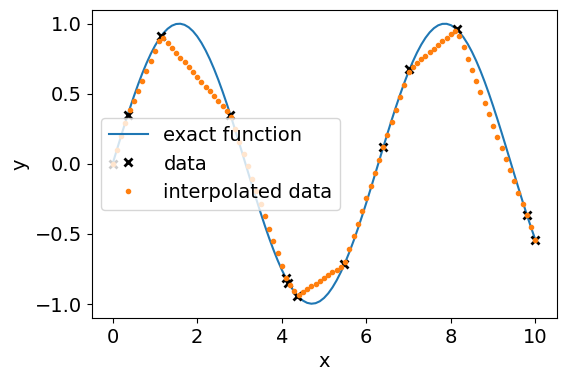

In [10]:
def randspace(a,b,h):
    x = np.array([a])
    while (x[-1]<b):  # Here is a good example of a while loop where the number of iterations are unknown in advance
        x = np.append(x,x[-1]+np.random.rand()*h)  # add to the array the next point
    x[-1]=b  # having stopped, overwrite the last element with b
    return x

M = 11
x0 = randspace(0,10,2)
y0 = np.sin(x0)

N = 101

x = np.linspace(0,10.0,N)   # new evaluation points
f = piece_p1_v3(x0,y0)

plt.figure(figsize=(6,4))
plt.plot(x,np.sin(x),label='exact function')
plt.plot(x0,y0,'kx',mew=2,label='data')
plt.plot(x,f(x),'.',label='interpolated data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

<font color='#2F4F4F'>

### Scipy interpolation

To a certain extent we are reinventing the wheel here as Python, or rather the `scipy` library has interpolation functions built-in; to get a piecewise linear interpolant we can use [`interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)

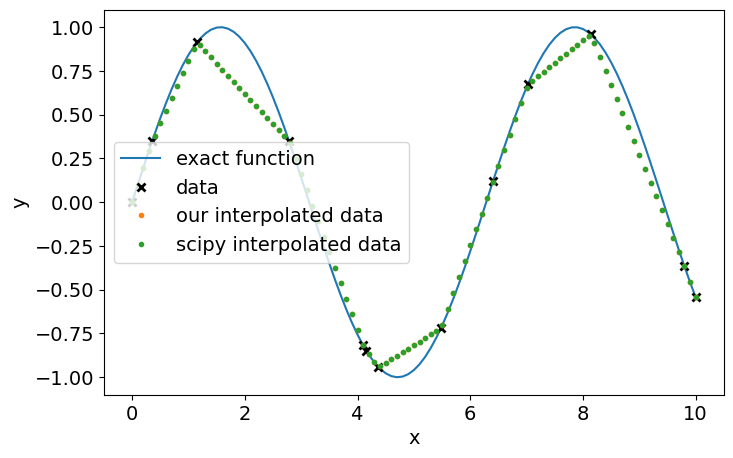

In [11]:
from scipy.interpolate import interp1d


g = interp1d(x0,y0,kind='linear')

plt.figure(figsize=(8,5))
plt.plot(x,np.sin(x),label='exact function')
plt.plot(x0,y0,'kx',mew=2,label='data')
plt.plot(x,f(x),'.',label='our interpolated data')
plt.plot(x,g(x),'.',label='scipy interpolated data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


<font color='#2F4F4F'>
As you can see, it looks like our interpolation is coincident with scipy's. We can check the agreement by plotting the difference:

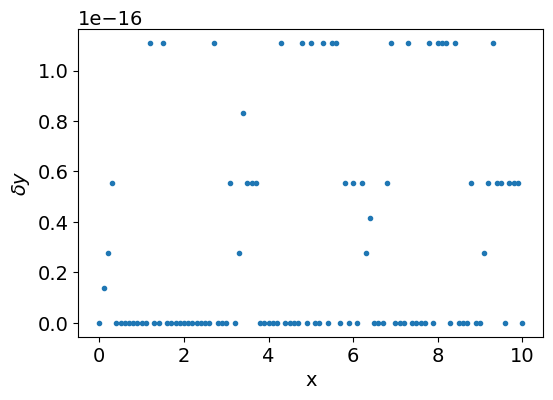

In [12]:
plt.figure(figsize=(6,4))
plt.plot(x,np.abs(f(x)-g(x)),'.',)
plt.xlabel('x')
plt.ylabel('$\delta y$')
plt.show()

<font color='#2F4F4F'>

The differences are at or below machine precision meaning the difference is probably just the order of the operations performed; slightly different rounding errors are accumulated.

We should stress here that it is really very useful to be able to replicate some built-in functions some of the time. Not using them as black boxes and having a good grasp of the fundamentals is very useful e.g. 

* should you need a niche implementation of a particular method which the built-in function cannot handle
* should the built-in function throw up something unexpected

We can also learn a lot about programming technique, for instance here we have discovered array broadcasting.

## Error

It is possible to perform a rigorous error analysis for linear interpolation and determine how we expect the errors to behave. We haven't time to explore this here, if you are keen you can find details in, e.g. Section 2.2.2 [Gautschi, *Numerical Analysis*](https://encore.st-andrews.ac.uk/iii/encore/record/C__Rb2075268). What comes out of the error analysis is that a piecewise linear approximation to a function $f(x)$ has error

$$|f(x)-p_1(x)| \sim h^2$$

where $h = \frac{b-a}{n-1}$ is the spacing of the knots, or the length of each subinterval. For example, for linear interpolation, if you are able to halve the spacing of the knots, i.e. double the total data points, you stand to quarter the error in your approximation. 

**This decrease of error with stepsize is referred to as the *convergence* of the method and is common to many areas of numerical analysis, such as numerical differentiation, integration and numerical solution to differential equations.**

<font color='#2F4F4F'>

### Application
    
We can check this convergence by varying the number of data points in our test case and plot the maximum error. We will plot the maximum error on a log-log plot alongside, $h,$ $h^2$ and $h^3$ so that we can be sure we obtain the predicted trend.
    
Later on we will consider cases where this prediction can break down.

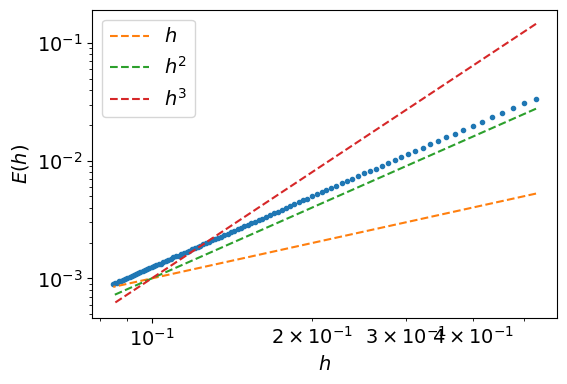

In [13]:
NN = 100                         # Choose how many resolutions to test
a = 0.0
b = 10.0
err_h = np.zeros(NN)             # store error
h = np.zeros(NN)                 # store h

x = np.linspace(0,10,500)       # we must choose high resolution evaluation points 
for M in range(NN):
    x0 = np.linspace(a,b,M+20)   # convergence is asymptotic, h<<1, so skip large h (M+20)
    y0 = np.sin(x0)
    
    f = piece_p1_v3(x0,y0)

    y = f(x) 
        
    err_h[M] = np.max(np.abs(y-np.sin(x))) # get the largest error in your set of evaluation points
    h[M] = x0[2]-x0[1]

plt.figure(figsize=(6,4))
plt.loglog(h,err_h,'.')
plt.loglog(h,0.01*h,'--',label='$h$')
plt.loglog(h,0.1*h**2,'--',label='$h^2$')
plt.loglog(h,h**3,'--',label='$h^3$')
plt.legend()
plt.xlabel('$h$')
plt.ylabel('$E(h)$')
plt.show()